In [1]:
import matplotlib.pyplot as plt
import numpy as np

from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise
from lowEBMs.Packages.Variables import variable_importer, Vars
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
from lowEBMs.Packages.Optimization import coremodule

import lowEBMs.Packages.Constants as const
from lowEBMs import update_plotstyle, moving_average
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
Year_volc, CWL_GMT,  EVA_GMT, CWLcorr_GMT=np.genfromtxt('Data/Volc_800_2000.txt',skip_header=1,unpack=True)

Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')

Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)

NORESM_1990_2005=SAT_VOLC-SAT_TREN

In [12]:
labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P0=np.array([70*4.2e6,210,2.5,1.165,1.165,1.165])
Pmin=np.array([1*4.2e6,190,1.9,0.9,0.9,0.9])
Pmax=np.array([100*4.2e6,240,3.3,1.3,1.3,1.3])
P_pert_ratio=1/10000

precision=1e-5
maxlength=int(100)
targetmode='Coupled'
target={'GMT':NORESM_1990_2005,'ZMT':ZMT_10}
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.1
num_params=6
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Volcanic_Budyko_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        
config_base=importer('Dev_Data/Optimization/Volcanic_Budyko.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Budyko_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Volcanic_Budyko.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


KeyboardInterrupt: 

In [3]:
time_HADCM3_str=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[0],delimiter=',',skip_header=1,dtype='str',unpack=True,encoding='ISO-8859-1')
time_HADCM3=np.zeros(len(time_HADCM3_str))
for i in range(len(time_HADCM3_str)):
    if time_HADCM3_str[i][-4]=='.':
        year=float(time_HADCM3_str[i][-3:])
    if time_HADCM3_str[i][-5]=='.':
        year=float(time_HADCM3_str[i][-4:])
    if time_HADCM3_str[i][4]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    if time_HADCM3_str[i][5]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    day=float(time_HADCM3_str[i][:2])/365
    time_HADCM3[i]=year+month+day
GMT_HADCM3=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[17],delimiter=',',skip_header=1,unpack=True,encoding='ISO-8859-1')
order=np.argsort(time_HADCM3)
GMT_HADCM3_smoothed=moving_average(GMT_HADCM3[order],12)
Time_HADCM3_smoothed=moving_average(time_HADCM3[order],12)

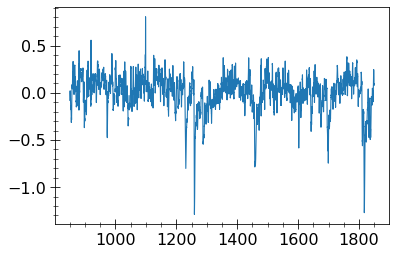

In [4]:
#plt.plot(Time_HADCM3_smoothed,GMT_HADCM3_smoothed)
#print(np.mean(GMT_HADCM3_smoothed))
#print(time_HADCM3[order][24-7])

start=0
end=0
for k in range(len(Time_HADCM3_smoothed)):
    if np.isnan(Time_HADCM3_smoothed[k]):
        start+=1
    else: break
for k in range(1,len(Time_HADCM3_smoothed)-1):
    if np.isnan(Time_HADCM3_smoothed[-k]):
        end+=1
    else: break
Time_int=np.array(Time_HADCM3_smoothed[start:-(end+1)], dtype=int)
Time_HADCM3_smoothed_corrected=Time_HADCM3_smoothed[start:-(end+1)]
GMT_HADCM3_smoothed_corrected=GMT_HADCM3_smoothed[start:-(end+1)]
k800=np.where(Time_int==800)[0]
k850=np.where(Time_int==850)[0]
k1850=np.where(Time_int==1850)[0]
Time_850_1850=Time_HADCM3_smoothed_corrected[k850[0]-1:k1850[0]-1]
GMT_850_1850=GMT_HADCM3_smoothed_corrected[k850[0]-1:k1850[0]-1]
GMT_850_1850_response=np.array(GMT_850_1850)-np.nanmean(GMT_850_1850)
plt.plot(Time_850_1850,GMT_850_1850_response)

In [8]:
#print(Time_850_1850)

In [5]:
labels=[['eqparam','c_ao'],['func3','a'],['func3','b'],['func4','factor_oc'],['func4','factor_kwv'],['func4','factor_kair']]
P0=np.array([70*4.2e6,210,2.5,1.165,1.165,1.165])
Pmin=np.array([1*4.2e6,190,1.9,0.9,0.9,0.9])
Pmax=np.array([100*4.2e6,240,3.3,1.3,1.3,1.3])
P_pert_ratio=1/10000

precision=1e-5
maxlength=int(10)
targetmode='Coupled'
target={'GMT':GMT_850_1850_response,'ZMT':ZMT_10}
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.1
num_params=6
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Budyko_HadCM3_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',4,2,True,True)
        
config_base=importer('Dev_Data/Optimization/Budyko_HadCM3.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',4,2,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Budyko_HadCM3_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Budyko_HadCM3.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Eq. State reached after 27026 steps, within 137.523193359375 seconds



[1979.8088799  1979.76869607 1979.84937494 1980.57038915 1979.04579356
 1979.36563129 1980.25254398 1979.80667505 1979.81108478 1979.80877026
 1979.80898954 1979.80046038 1979.81746004]
1e-08
[2.94002407e+08 2.09990471e+02 2.50014486e+00 1.16500013e+00
 1.16500001e+00 1.16500051e+00]
Iteration no.1
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Eq. State reached after 27026 steps, within 135.37584733963013 seconds



[1884.58501118 1884.54164585 1884.62866771 1885.32398417 1883.84455724
 1884.18120036 1884.98928848 1884.58291754 1884.58717899 1884.58497384
 1884.58512265 1884.57683436 1884.59342298]
1.735838480679655e-07
[2.94047465e+08 2.09829968e+02 2.50243596e+00 1.16500237e+00
 1.16500008e+00 1.16500921e+00]
Iteration no.2
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Eq. State reached after 26025 steps, within 132.5803120136261 seconds



[1867.30154383 1867.25702469 1867.34588368 1868.2059905  1866.39210024
 1866.92598631 1867.6769611  1867.29939205 1867.30369565 1867.30153268
 1867.30143815 1867.29313265 1867.30972212]
6.880240332057836e-07
[2.94229832e+08 2.09049968e+02 2.51087521e+00 1.16501131e+00
 1.16499989e+00 1.16504366e+00]
Iteration no.3
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Eq. State reached after 19018 steps, within 96.21524596214294 seconds



[1315.35168609 1315.28905998 1315.41414901 1318.3719705  1312.39335216
 1315.51581821 1315.19080065 1315.34902109 1315.35462102 1315.35301321
 1315.35048585 1315.33150456 1315.37167052]
2.568420278071553e-07
[2.94325667e+08 2.08090243e+02 2.50951173e+00 1.16501565e+00
 1.16499793e+00 1.16507481e+00]
Iteration no.4
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Eq. State reached after 19018 steps, within 95.82229781150818 seconds



[1085.44055266 1085.40307982 1085.47811128 1085.88218008 1085.00158875
 1085.38117447 1085.49958039 1085.43909386 1085.4420115  1085.44048661
 1085.44061872 1085.43542973 1085.44584576]
3.0047867580581104e-07
[2.94392918e+08 2.07924869e+02 2.51009284e+00 1.16501829e+00
 1.16499805e+00 1.16508426e+00]
Iteration no.5
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Eq. State reached after 19018 steps, within 96.66444849967957 seconds



[1072.45782024 1072.4222634  1072.493252   1072.80691605 1072.11078819
 1072.39012482 1072.52519672 1072.45644964 1072.45919088 1072.45771912
 1072.45792136 1072.45325739 1072.46222515]
1.4098963065912351e-06
[2.94691468e+08 2.07311451e+02 2.51320332e+00 1.16502996e+00
 1.16499891e+00 1.16512242e+00]
Iteration no.6
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Eq. State reached after 19018 steps, within 96.08556580543518 seconds



[1048.50567823 1048.47703705 1048.53434564 1048.23277457 1048.74617156
 1048.44189993 1048.56945488 1048.5111784  1048.50017492 1048.50931625
 1048.50203922 1048.55905136 1048.45210378]
8.101655699524458e-07
[2.94829963e+08 2.07571412e+02 2.51489122e+00 1.16500305e+00
 1.16498111e+00 1.16486085e+00]
Iteration no.7
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Eq. State reached after 19018 steps, within 95.26053404808044 seconds



[1050.09671698 1050.06451125 1050.12934154 1050.32310417 1049.87201354
 1050.02051977 1050.17321066 1050.09561547 1050.09776388 1050.09661334
 1050.09676589 1050.09439012 1050.0990529 ]
4.301466218436708e-07
[2.94913146e+08 2.07450140e+02 2.51596398e+00 1.16500584e+00
 1.16498131e+00 1.16486691e+00]
Iteration no.8
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Eq. State reached after 19018 steps, within 95.56582355499268 seconds



[1044.52173498 1044.49063742 1044.55305831 1044.6939741  1044.35383658
 1044.44447967 1044.59962268 1044.5211183  1044.52235237 1044.52193674
 1044.52153343 1044.52347781 1044.51992681]
1.735184868753024e-06
[2.95236230e+08 2.07081264e+02 2.52036094e+00 1.16501230e+00
 1.16497920e+00 1.16484831e+00]
Iteration no.9
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Eq. State reached after 19018 steps, within 94.88071012496948 seconds


ValueError: x and y must have same first dimension, but have shapes (12167,) and (12012,)

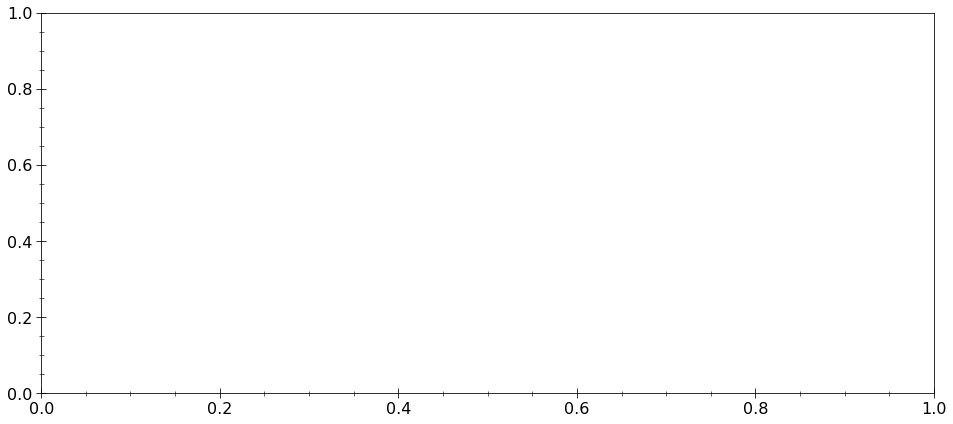

In [71]:
fig,ax=plt.subplots(figsize=(16,7))
for k in [0,1,5,9]:
    plt.plot(np.arange(850*365,1850*365,30)/365,data[1][k,0],label=k)
plt.plot(Time_850_1850,GMT_850_1850_response)
plt.legend()
plt.xlim(1800,1850)

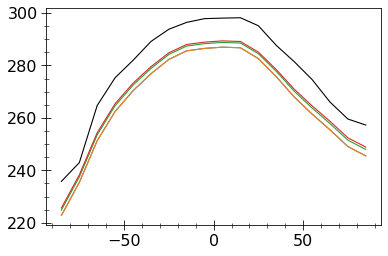

In [57]:
for k in [0,1,5,9]:
    plt.plot(Vars.Lat,data[0][k,0])
plt.plot(Lat_10,ZMT_10,c='k')

In [136]:
j=0
time=[]
t=850*365*24*60*60
for i in range(0,365*1000):
    month=int((i%365)/365*12)
    day=int(i%(365/12))
    #print(month)
    t+=24*60*60
    if day==15:
        time.append(t)
        j+=1
print(np.array(time)[:120]/(365*24*60*60))
#np.arange(850*365,1850*365,30)

[850.04383562 850.12876712 850.2109589  850.29589041 850.37808219
 850.4630137  850.54520548 850.62739726 850.71232877 850.79452055
 850.87945205 850.96164384 851.04657534 851.12876712 851.2109589
 851.29589041 851.37808219 851.4630137  851.54520548 851.62739726
 851.71232877 851.79452055 851.87945205 851.96164384 852.04657534
 852.12876712 852.2109589  852.29589041 852.37808219 852.4630137
 852.54520548 852.62739726 852.71232877 852.79452055 852.87945205
 852.96164384 853.04657534 853.12876712 853.2109589  853.29589041
 853.37808219 853.4630137  853.54520548 853.62739726 853.71232877
 853.79452055 853.87945205 853.96164384 854.04657534 854.12876712
 854.2109589  854.29589041 854.37808219 854.4630137  854.54520548
 854.62739726 854.71232877 854.79452055 854.87945205 854.96164384
 855.04657534 855.12876712 855.2109589  855.29589041 855.37808219
 855.4630137  855.54520548 855.62739726 855.71232877 855.79452055
 855.87945205 855.96164384 856.04657534 856.12876712 856.2109589
 856.29589041

In [23]:
config_CTRL2=importer('Dev_Data/Optimization/Budyko_HadCM3_CTRL.ini')
variable_importer(config_CTRL2,control=True)
config_CTRL2,ParasCTRL=add_sellersparameters(config_CTRL2,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',4,2,True,True)

#add_parameters
Time_Spinup2,ZMT_Spinup2,GMT_Spinup2=rk4alg(model_equation,config_CTRL2['eqparam'],config_CTRL2['rk4input'],config_CTRL2['funccomp'],daily=True)

Loading Configuration from: Dev_Data/Optimization/Budyko_HadCM3_CTRL.ini
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


/Home/siv32/bsc029/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Eq. State reached after 63062 steps, within 78.05740189552307 seconds


In [ ]:
config_base2=importer('Dev_Data/Optimization/Budyko_HadCM3.ini')
variable_importer(config_base2)

config_base2,ParasCTRL=add_sellersparameters(config_base2,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',4,2,True,True)

Vars.T,Vars.T_global=ZMT_Spinup2[-1],GMT_Spinup2[-1]
Time_full,ZMT_full,GMT_full=rk4alg(model_equation,config_base2['eqparam'],config_base2['rk4input'],config_base2['funccomp'],daily=True)

Loading Configuration from: Dev_Data/Optimization/Budyko_HadCM3.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


1849.958904109589
1849.916095890411


(1800, 1850)

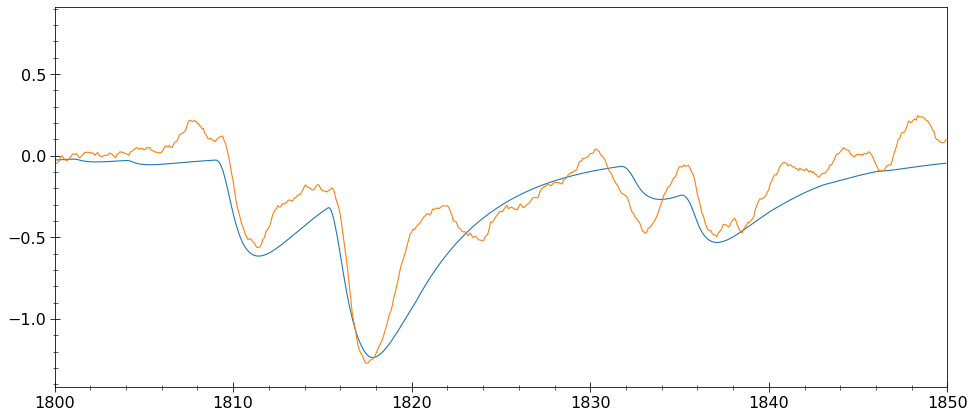

In [19]:
fig,ax=plt.subplots(figsize=(16,7))
print(Time_full[-1]/const.time_sec_year)
print(Time_850_1850[-1])
plt.plot(Time_850_1850,GMT_full[:-1]-GMT_full[0])
plt.plot(Time_850_1850,GMT_850_1850_response)
plt.xlim(1800,1850)

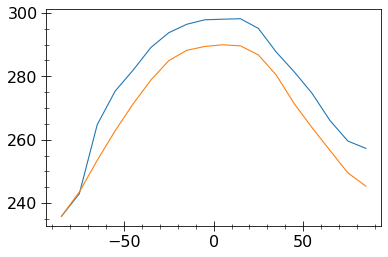

In [26]:
plt.plot(Lat_10,ZMT_10)
#plt.plot(Vars.Lat,ZMT_Spinup2[-1])

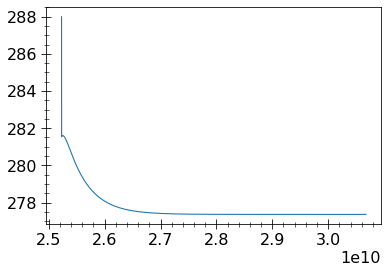

In [24]:
plt.plot(Time_Spinup2,GMT_Spinup2)